In [144]:
# 02_features.ipynb – Feature Engineering

In [145]:
# 1. Bibliotheken
import pandas as pd
import numpy as np

In [146]:
# 2. Daten einlesen
df = pd.read_csv("../data/model_input.csv")
print(df.shape)


(6274, 12)


In [147]:
# 3. Fahrzeug-Segment-Mapping - # Mapping basierend auf Wikipedia: https://de.wikipedia.org/wiki/Fahrzeugklasse
# Lese externes Mapping aus vehicle_segment.csv
mapping_df = pd.read_csv("../data/vehicle_segment.csv")  # ggf. relativen Pfad anpassen
segment_map = dict(zip(mapping_df['Vehicle Class'], mapping_df['Segment']))

# Wende Mapping an
df['Vehicle Segment'] = df['Vehicle Class'].map(segment_map)

# Prüfen ob Mapping vollständig war
unmapped = df['Vehicle Segment'].isnull().sum()
print(f"Unzugeordnete Fahrzeugklassen: {unmapped}")


Unzugeordnete Fahrzeugklassen: 0


In [148]:
#4. Feature Engineering Verhältnis Verbrauch Stadt / Autobahn
#df['consumption_ratio'] = df['Fuel Consumption City (L/100 km)'] / df['Fuel Consumption Hwy (L/100 km)'].replace(0, np.nan)
# Feature Engineering: Verhältnis Verbrauch Stadt / Autobahn
# Ziel: Stabil, keine Division durch 0, Extremwerte begrenzen

# Division durchführen mit Ersatz für 0-Werte
#df['consumption_ratio'] = df['Fuel Consumption City (L/100 km)'] / df['Fuel Consumption Hwy (L/100 km)'].replace(0, np.nan)

# Fehlende oder unendlich große Werte ersetzen (z. B. durch neutralen Mittelwert 1.0)
#df['consumption_ratio'] = df['consumption_ratio'].fillna(1.0)

# Extremwerte begrenzen – typische Range: 0.5 (fast nur Autobahn) bis 1.5 (viel Stadtverkehr)
#df['consumption_ratio'] = df['consumption_ratio'].clip(0.5, 1.5)

#Anzahl Gänge aus Getriebe extrahieren (z. B. 'A6', 'M5', 'AV')
df['gear_count'] = df['Transmission'].str.extract(r'(\d{1,2})').astype(float).fillna(0)

# Neues Zielattribut: kombinierter Verbrauch (Standard = 55 % Stadt, 45 % Autobahn)
df['combined_consumption'] = (
    df['Fuel Consumption City (L/100 km)'] * 0.55 +
    df['Fuel Consumption Hwy (L/100 km)'] * 0.45
)

print(df['gear_count'].value_counts())
print(df['combined_consumption'].describe())



gear_count
6.0     2784
8.0     1513
7.0      880
9.0      329
5.0      276
0.0      241
10.0     188
4.0       63
Name: count, dtype: int64
count    6274.000000
mean       10.998436
std         2.900083
min         4.110000
25%         8.932500
50%        10.552500
75%        12.665000
max        23.910000
Name: combined_consumption, dtype: float64


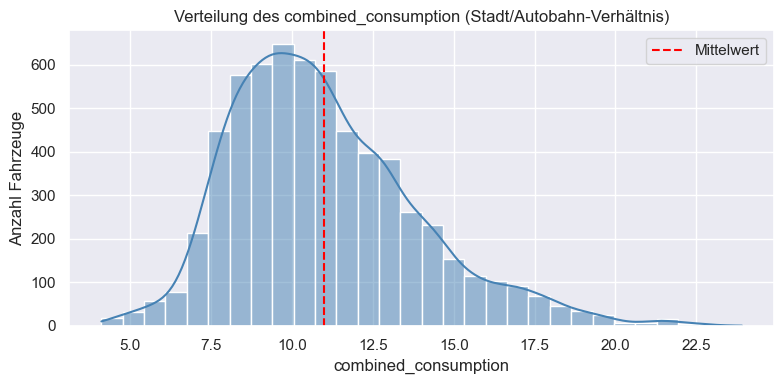

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stil setzen
sns.set_theme()

# Histogramm anzeigen
plt.figure(figsize=(8, 4))
sns.histplot(df['combined_consumption'], bins=30, kde=True, color="steelblue")

# Beschriftungen
plt.title("Verteilung des combined_consumption (Stadt/Autobahn-Verhältnis)")
plt.xlabel("combined_consumption")
plt.ylabel("Anzahl Fahrzeuge")
plt.axvline(df['combined_consumption'].mean(), color='red', linestyle='--', label='Mittelwert')
plt.legend()
plt.tight_layout()
plt.show()


In [150]:
# OneHot-Encoding der neuen Fahrzeugsegmente
df = pd.get_dummies(df, columns=['Vehicle Segment'], drop_first=False)
print(df.filter(like='Vehicle Segment_').columns)



Index(['Vehicle Segment_Kleinstwagen', 'Vehicle Segment_Kleinwagen',
       'Vehicle Segment_Kompaktklasse', 'Vehicle Segment_Kompaktklasse Kombi',
       'Vehicle Segment_Mittelklasse', 'Vehicle Segment_Mittelklasse Kombi',
       'Vehicle Segment_Nutzfahrzeug', 'Vehicle Segment_Nutzfahrzeug leicht',
       'Vehicle Segment_Oberklasse', 'Vehicle Segment_SUV gross',
       'Vehicle Segment_SUV kompakt', 'Vehicle Segment_Spezialfahrzeug',
       'Vehicle Segment_Sportwagen', 'Vehicle Segment_Van / MPV'],
      dtype='object')


In [151]:
# 5. OneHot-Encoding für Fuel Type
df = pd.get_dummies(df, columns=['Fuel Type'], drop_first=False)
print(df.filter(like='Fuel Type_').columns)


Index(['Fuel Type_D', 'Fuel Type_E', 'Fuel Type_N', 'Fuel Type_X',
       'Fuel Type_Z'],
      dtype='object')


In [152]:
# 6. Binär-Feature: is_automatic aus Transmission
df['is_automatic'] = df['Transmission'].apply(lambda x: 1 if 'A' in x else 0)
# Ergänzung: is_manual ergänzen, damit spätere Modellfeatures vollständig sind
if 'is_manual' not in df.columns:
    df['is_manual'] = 1 - df['is_automatic']

In [153]:
# 7. Ziel- und Prädiktoren-Spalten vorbereiten
target = 'combined_consumption'
features = [
    'Engine Size(L)',
    'Cylinders',
    'is_automatic',  # is_manual redundant
    'gear_count',

    # Die 6 häufigsten Fahrzeugsegmente:
    'Vehicle Segment_Kompaktklasse',
    'Vehicle Segment_Mittelklasse',
    'Vehicle Segment_SUV kompakt',
    'Vehicle Segment_SUV gross',
    'Vehicle Segment_Oberklasse',
    'Vehicle Segment_Kleinwagen',

    # Die 3 häufigsten Treibstoffarten:
    'Fuel Type_X',  # Premium Benzin
    'Fuel Type_Z',  # Regular Benzin
    'Fuel Type_D',  # Diesel – sinnvoll, wie du korrekt erkannt hast
]

In [154]:
# 8. Ausgabe
print("Finale Features für das Modell:")
print(features)
print("\nShape (X):", df[features].shape, "| Shape (y):", df[target].shape)


Finale Features für das Modell:
['Engine Size(L)', 'Cylinders', 'is_automatic', 'gear_count', 'Vehicle Segment_Kompaktklasse', 'Vehicle Segment_Mittelklasse', 'Vehicle Segment_SUV kompakt', 'Vehicle Segment_SUV gross', 'Vehicle Segment_Oberklasse', 'Vehicle Segment_Kleinwagen', 'Fuel Type_X', 'Fuel Type_Z', 'Fuel Type_D']

Shape (X): (6274, 13) | Shape (y): (6274,)


In [155]:
# Finale Features und Zielvariable speichern
X = df[features]
y = df[target]
X.to_csv('../data/X_features.csv', index=False)
y.to_csv('../data/y_target.csv', index=False)
